# Create Personalized Features

For a challenge like Optimized Battery Charging (OBC), you know that different users have different device-charging behaviors. Some users may charge overnight, whereas others may charge intermittently, and throughout the day. 

So, how can you represent these unique behaviors as **features** that an ML model can learn from? 
> Where **features** are measurable traits that can help a model make a desired prediction. A feature is typically a single numerical value or class that you can represent in one column of data. 

> To represent individual behaviors, it follows that you need to calculate **features that are unique to each individual**. 

In this example notebook, I will show you one method of featurizing individual user's past charging behavior, by going through the following steps:
* Loading data — Reading in some small training and test sets of data and doing initial explorations
* Exploring data — Exploring one user in detail
* Creating user-specific, summary statistics — For each user, calculating statistics about their past charging behavior
* Saving the data

I'll conclude by showing how a simple, linear regression model (a baseline model) trained on this data performs. 

### The data

The data you'll be give for this notebook has undergone some pre-processing: 
* It contains only a fraction of the data you have access to in Trove (~100 of the 10k devices)
* It has been split into separate train and test sets
* It is _all_ plug-in events (as can be seen by the `stream` and `value` columns)
* The battery percentage level at the start of a plug-in event has been recorded as the column `start_batt_level`
* `start`, `end`, and `user_id` columns are similar to what you'll see in the provided data in Trove
* There are no missing values

The point of this example is to focus on user-specific feature engineering rather than providing you a complete answer to the OBC challenge. **You'll still be expected to featurize the larger Trove dataset all on your own for completing the OBC project.** 
 
I'll start by importing some typical libraries.

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

---
## Load and Explore the Data

I've placed this data in a `data/` directory, and recommend you do the same if you are running the example on your own machine.

In [2]:
# get saved smol data as df's
train_small = pd.read_pickle('data/train_small.pkl')
test_small = pd.read_pickle('data/test_small.pkl')

train_small.head()

,start,end,stream,value,user_id,duration,start_batt_level
0,2020-03-02 00:00:00,2020-03-02 00:26:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,26.0,6.0
228,2020-03-02 00:27:00,2020-03-02 01:03:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,36.0,19.0
666,2020-03-02 01:45:00,2020-03-02 02:07:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,22.0,37.0
793,2020-03-02 02:15:00,2020-03-02 02:29:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,14.0,41.0
1834,2020-03-02 05:25:00,2020-03-02 05:35:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,10.0,29.0


In [3]:
# confirm the types are as expected (esp datetimes)
train_small.dtypes

start               datetime64[ns]
end                 datetime64[ns]
stream                      object
value                      float64
user_id                     object
duration                   float64
start_batt_level           float64
dtype: object

One thing that can occur during a data split, is that users for whom we only have one data point will either end up in the train OR the test set of data.

One data point is not enough to be making a prediction for OBC, and so these users are considered out-of-scope for OBC, and we can _remove_ them. In your own work on this challenge you may decide, as a design choice, to remove all users under some number of **cutoff data points** greater than 1. After all, we need data about past usage to be able to make predictions about the future! 

Below, you'll see that one user (and one row of data) appears in our test data and not the training data; therefore, I remove this point before I proceed. 

In [4]:
# check that the train and test sets contains the same users

# the list, unique_test_users should be empty if all users match
# or it will hold any users that appear in the test but not train data
unique_test_users = list(set(test_small['user_id'].unique()) - set(train_small['user_id'].unique()))
print(unique_test_users)

# find and display all rows with just this user
selection = test_small[test_small['user_id'].isin(unique_test_users)]
selection


['ade906b0-6882-4b9f-ab8c-b15d0f7e3e77']


,start,end,stream,value,user_id,duration,start_batt_level
83,2020-03-02 00:01:00,2020-03-02 00:12:00,/device/isPluggedIn,1.0,ade906b0-6882-4b9f-ab8c-b15d0f7e3e77,11.0,73.0


In [5]:
# it is just one row, meaning we have just one data point for this user
# not enough to infer any general behaviors for OBC

# remove with the negation of the above filter with ~
test_small = test_small[~test_small['user_id'].isin(unique_test_users)]

In [6]:
# checking my work, I will run this command again expecting NO unique test set users
unique_test_users = list(set(test_small['user_id'].unique()) - set(train_small['user_id'].unique()))
print(unique_test_users)

[]


---
## Explore One User

In the below code, I am taking a look at one user's data in detail. 

Looking at the rows of data, you can begin to see some patterns in _when_ (start) and _how long_ (duration) this user typically charges their device in the rows of data. It is hard to see in the rows and so I also select a few rows of data to display in a graph to get another view.

If you try to run this code on other users, the 3-day display code may break as it relies on the assumption that there are three consecutive days of data to read from at the start of a user's charge history.

In [7]:
# selecting one user
select_user = train_small['user_id'].unique()[9]
one_user_filter = train_small['user_id'] == select_user

# grabbing select data and viewing a few rows
one_user_df = train_small[one_user_filter].copy()
one_user_df.head(10)

,start,end,stream,value,user_id,duration,start_batt_level
14,2020-03-02 00:00:00,2020-03-02 00:32:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,32.0,89.0
827,2020-03-02 02:23:00,2020-03-02 04:34:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,131.0,90.0
2754,2020-03-02 09:08:00,2020-03-02 09:23:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,15.0,93.0
4974,2020-03-02 19:09:00,2020-03-02 20:25:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,76.0,84.0
9227,2020-03-03 04:49:00,2020-03-03 05:53:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,64.0,82.0
15692,2020-03-03 18:44:00,2020-03-03 19:45:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,61.0,80.0
24334,2020-03-04 04:37:00,2020-03-04 06:52:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,135.0,83.0
35127,2020-03-04 18:42:00,2020-03-04 19:43:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,61.0,90.0
44541,2020-03-05 03:53:00,2020-03-05 04:56:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,63.0,87.0
63208,2020-03-05 21:58:00,2020-03-05 22:16:00,/device/isPluggedIn,1.0,98688ee1-3deb-4f61-92c5-e0db9e5421b7,18.0,52.0


In [1]:
# plotting one day's worth of charging data

# relies on a time-sorted df
start_date = one_user_df['start'].iloc[0]
end_date = one_user_df['start'].iloc[0] + datetime.timedelta(days=1)
one_day = (one_user_df['start'] >= start_date) & (one_user_df['start'] < end_date)

# make plot
plt.figure(figsize=(12,4))
plt.plot(one_user_df[one_day]['start'], one_user_df[one_day]['duration'], '.' , markersize=10)
plt.xlabel('start time', fontsize=14)
plt.ylabel('charge duration', fontsize=14);

NameError: name 'one_user_df' is not defined

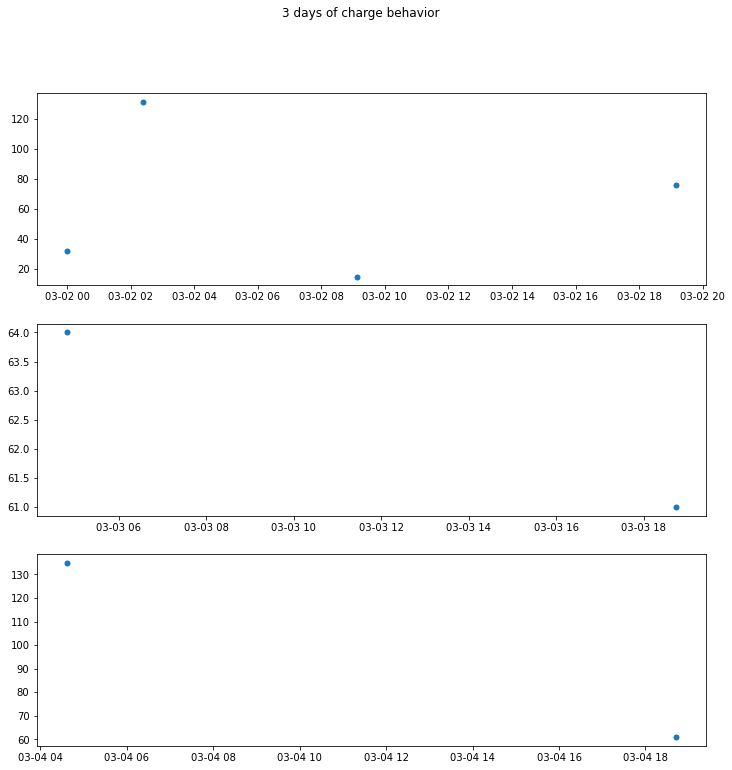

In [9]:
# plot a few days
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,12))
fig.suptitle('3 days of charge behavior')

start_date = one_user_df['start'].iloc[0]
end_date = one_user_df['start'].iloc[0] + datetime.timedelta(days=1)
day_1 = (one_user_df['start'] >= start_date) & (one_user_df['start'] < end_date)
day_2 = (one_user_df['start'] >= end_date) & (one_user_df['start'] < end_date + datetime.timedelta(days=1))
day_3 = (one_user_df['start'] >= end_date + datetime.timedelta(days=1)) & (one_user_df['start'] < end_date + datetime.timedelta(days=2))

ax1.plot(one_user_df[day_1]['start'], one_user_df[day_1]['duration'], '.' , markersize=10)
ax2.plot(one_user_df[day_2]['start'], one_user_df[day_2]['duration'], '.' , markersize=10)
ax3.plot(one_user_df[day_3]['start'], one_user_df[day_3]['duration'], '.' , markersize=10)


---
## Create Summary Statistics

From the graphs above, it looks like this user does have repetitive (predictable) charging behavior—charging for a long time starting around ~2-6am and charging for a shorter time after 6pm (18:00hrs). 

If you explore other user's data you may find different patterns or not-enough data to infer any general patterns (which brings me back to the idea of having a cutoff # of data points that we require before we engage OBC). But let's say, we have a user like the one in this example... 

How might we represent repeated, user behavior as a numerical feature?
> **Summary statistics for individual users** - statistics that summarize information for each unique `user_id` in the dataset. 

Summary statistics for this dataset include:
* Mean or median charge durations for a user around a particular time frame, e.g., for the user above, the mean charge duration between 2-6am might be ~100mins, whereas a mean charge duration between 6-8pm might be ~65mins. 
* Standard deviation for charge duration around that same time frame.
* Counts of how many data points you have for each user within a particular time frame (you may not want to engage OBC during a time period unless you have enough data)

### Match stats with individual users

To create features that are unique to each user, complete a few steps:
1. **Filter for unique user information** — Iterate over each unique `user_id` and select only the rows of data for a unique user. 
2. **Select relevant data** — Use the start time to select the rows of data that correspond with the time frame you are interested in; this is typically referred to as a _time-window_.
3. **Calculate stats** — Calculate stats on the selected rows, e.g., median charge duration, standard dev, and counts of data.
4. **Store the stats** — Store the information either in a new column in a DataFrame. One way to do so is by storing the info in a dictionary that is organized in such a way as to be easily merged into a DataFrame with keys that are unique to each user and time-window.

Recall that, in this case, the stats are calculated on _past_ training data, and then these features are added to both the training and test sets in a new column. This will be clearer in the example code, below. 

> **EXERCISE**: Read the code in the below cell and see if you can understand it, then read the written explanation that follows. 

In [11]:
# create empty dictionaries to store stats
mean_dur_2hr = {} 
std_dev_2hr = {}

# iterate over all unique user id's
for user_id in train_small['user_id'].unique():
    
    # filter for unique user_id data
    user_df = train_small[train_small['user_id']==user_id]
    
    # iterate over a 24hr range in 2hr increments (0, 2, 4, ..., 22)
    for hr_window in np.arange(0, 24, step=2):
        
        # select relevant data — utilize start time to get a user's data in 2hr chunks
        hour_condition = (user_df['start'].dt.hour == hr_window) | (user_df['start'].dt.hour == hr_window+1)
        user_in_window = user_df[hour_condition].copy()
        
        # calculate user stats about charge duration for the selected time window
        mean_charge_duration_2hr = np.mean(user_in_window['duration'])
        std_charge_duration_2hr = np.std(user_in_window['duration'])
        
        # save stats in a dictionary, each stat is associated with a specific key
        # keys will be user_id + _ + hr_window
        key = user_id+'_'+str(hr_window)
        mean_dur_2hr[key] = (mean_charge_duration_2hr)
        std_dev_2hr[key] = (std_charge_duration_2hr)


### Example: 2hr time windows

In the example code above, I calculate some user stats, using only the training data—which is in the past, relative to the test data—for a user's typical charge duration in 2hr time-windows (0-2am, 2-4am, 4-6am, etc.). I then save these stats in a dictionary whose **keys** are unique to the user and time window. 

If you'd like to learn more about the dictionary structure and accessing items by keys, check out [this documentation on dictionaries](https://www.w3schools.com/python/python_dictionaries_access.asp). 

Later, I will use this unique key to align merge these stats into a new column of data in my train and test sets; aligning based on the relevant user and time window.

> You can follow a similar process for any other size window or stat you are interested in, e.g., median charge durations for 4hr time windows or counts of data points for each user.

For now, as a check, I'll take a look at one user's worth of dictionary contents. Some values may be `nan` values which indicates that there is no recorded charging data for that user, during that time window.


In [12]:
# see what a sample of the dictionary contents look like for a user
# first 12 items should show (key, value)

print('Mean vals: \n')
print(list(mean_dur_2hr.items())[:12])
print()
print('Std dev vals: \n')
print(list(std_dev_2hr.items())[:12])


Mean vals: 

[('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0', 28.08108108108108), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_2', 12.588235294117647), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_4', 18.37037037037037), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_6', 24.983050847457626), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_8', 17.666666666666668), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_10', 20.2), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_12', 18.333333333333332), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_14', 11.81578947368421), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_16', 13.0), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_18', nan), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_20', nan), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_22', 26.58823529411765)]

Std dev vals: 

[('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0', 23.89886164695827), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_2', 10.192608761077873), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_4', 17.35286964879328), ('fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_6', 26.107659454990475), (

Next, I am creating a `key` column in both my train and test sets that matches the keys in my created dictionaries. This will be helpful for merging this information into a new feature column. 

I am creating this key in two steps: 
1. Creating a number to indicate which 2hr time window a row of data falls in, and 
2. Concatenating that number with an underscore and the `user_id` column to create a key string

Recall that using an `.apply()` and `lambda x` function _applies_ a simple function to all rows of `x`, which often refers to a column variable that is specified right before the `.apply()` (the `start` column in this case. 

In [13]:
# create a unique key column that matches the dictionary keys
# by concatenating user_id + 2hr_window
# hour minus hour modulo 2 creates even windows, 0, 2, 4, etc. that match the 2hr window
train_small['2hr_window'] = train_small['start'].apply(lambda x: (x.hour - x.hour%2))
test_small['2hr_window'] = test_small['start'].apply(lambda x: (x.hour - x.hour%2))

# create the same unique key by concatenating user_id + hr_window
train_small['key'] = train_small['user_id']+'_'+ train_small['2hr_window'].astype(str)
test_small['key'] = test_small['user_id']+'_'+test_small['2hr_window'].astype(str)

# view a few rows to verify the key col was created successfully
train_small.head()

,start,end,stream,value,user_id,duration,start_batt_level,2hr_window,key
0,2020-03-02 00:00:00,2020-03-02 00:26:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,26.0,6.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0
228,2020-03-02 00:27:00,2020-03-02 01:03:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,36.0,19.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0
666,2020-03-02 01:45:00,2020-03-02 02:07:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,22.0,37.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0
793,2020-03-02 02:15:00,2020-03-02 02:29:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,14.0,41.0,2,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_2
1834,2020-03-02 05:25:00,2020-03-02 05:35:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,10.0,29.0,4,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_4


Finally, I can use this `key` column and the keys of my created dictionaries to add new, statistical feature columns to both my train and test sets of data. 

The code is relatively simple: 
* I first check if a dictionary holds a `nan` value, and if so, I replace it with a 0
* If there is a value in the dictionary, I get that value associated with the `key`

**Note**: Replacing `nan`'s with 0's is a choice; you could instead choose to take an average of the surrounding window values, or replace with a global mean, or remove these points all together. All strategies have tradeoffs, and replacing with 0 means that, in this case, OBC will be more likely to under-estimate any charge lengths that occur for a user during this time frame (which is not too costly of an error, and one I am willing to accept). 

After running this code for both train and test sets, I should have two new columns for my two stats: `mean_dur_2hr` and `std_2hr`. Recall that stats for the same time-window + user should be the same, and so repeated values are expected!

In [14]:
# create statistical feature columns by aligning dictionary keys with the key column

train_small['mean_dur_2hr'] = train_small['key'].apply(lambda x: 
                                                       0 if math.isnan(mean_dur_2hr[x])
                                                       else mean_dur_2hr[x])

train_small['std_2hr'] = train_small['key'].apply(lambda x: 
                                                  0 if math.isnan(std_dev_2hr[x])
                                                  else std_dev_2hr[x])

# same but for test data
test_small['mean_dur_2hr'] = test_small['key'].apply(lambda x: 
                                                     0 if math.isnan(mean_dur_2hr[x])
                                                     else mean_dur_2hr[x])

test_small['std_2hr'] = test_small['key'].apply(lambda x: 
                                                0 if math.isnan(std_dev_2hr[x])
                                                else std_dev_2hr[x])


In [15]:
# check your work
# you should see the new feature columns as the end of the train and test datasets
train_small.head()

,start,end,stream,value,user_id,duration,start_batt_level,2hr_window,key,mean_dur_2hr,std_2hr
0,2020-03-02 00:00:00,2020-03-02 00:26:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,26.0,6.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0,28.081081,23.898862
228,2020-03-02 00:27:00,2020-03-02 01:03:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,36.0,19.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0,28.081081,23.898862
666,2020-03-02 01:45:00,2020-03-02 02:07:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,22.0,37.0,0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_0,28.081081,23.898862
793,2020-03-02 02:15:00,2020-03-02 02:29:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,14.0,41.0,2,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_2,12.588235,10.192609
1834,2020-03-02 05:25:00,2020-03-02 05:35:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,10.0,29.0,4,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_4,18.370370,17.352870


In [16]:
test_small.head()

,start,end,stream,value,user_id,duration,start_batt_level,2hr_window,key,mean_dur_2hr,std_2hr
811883,2020-03-23 02:21:00,2020-03-23 02:26:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,5.0,69.0,2,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_2,12.588235,10.192609
817282,2020-03-23 05:38:00,2020-03-23 06:28:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,50.0,52.0,4,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_4,18.370370,17.352870
819057,2020-03-23 06:41:00,2020-03-23 07:03:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,22.0,71.0,6,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_6,24.983051,26.107659
819904,2020-03-23 07:08:00,2020-03-23 07:13:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,5.0,74.0,6,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_6,24.983051,26.107659
820815,2020-03-23 07:36:00,2020-03-23 07:47:00,/device/isPluggedIn,1.0,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5,11.0,69.0,6,fd53a044-3e2f-43dd-a42b-5a6e702fb3d5_6,24.983051,26.107659


In [17]:
# a good idea is to check for any null values that may indicate an error in my code
print(train_small.isnull().sum())
print()
print(test_small.isnull().sum())


start               0
end                 0
stream              0
value               0
user_id             0
duration            0
start_batt_level    0
2hr_window          0
key                 0
mean_dur_2hr        0
std_2hr             0
dtype: int64

start               0
end                 0
stream              0
value               0
user_id             0
duration            0
start_batt_level    0
2hr_window          0
key                 0
mean_dur_2hr        0
std_2hr             0
dtype: int64


---
## Create (More) Features

At this point, you have an example of creating statistical features about individual user's charging habits!

And you should have a good idea of how to create more features like this for different statistical values, different time windows, and so on. Feel free to experiment or start with the exercise below.

> **EXERCISE**: Create two more user-specific features, `median_2hr` and `count_2hr`, which record the most common charge duration and the number of data points you have about a user's plug-in charge patterns for a specific user in 2hr time-windows. 

### Time-based features

Another type of feature that is really useful for time-series tasks, is timestamp-based features. 

To extract a time-based feature, the process is simpler than for user-specific features:
1. Filter for a timestamp you are interested in.
2. Extract one piece of useful information, e.g., the hour, the month, or whether that timestamp indicates a weekend or not, etc.
3. Store that information in a new column of data. 

It is important that you only use the time-based information that you expect to have at the the `start` of a plugin event. This is information we expect to have when we make a prediction; any information about the `end` of a plugin event would be like seeing into the future, and would constitute data leakage. 

I will leave this type of feature extraction up to you; you can read about several extractable timestamp attributes in the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html).


In [18]:
## TODO: Experiment with creating your own features!



---
## Save Your Data

Recall that this data is just a fraction of what you are provided in Trove, and so it is only an example of how you might create personalized features and save your data. 

With that in mind, one of the last things to mention is best practices for saving your data. 

Before you use your data to train a model, it is convention to save it in a specific format:
> 1. Your target variable should be the _last_ column in the dataset
> 2. All other columns should be different input features (other information should be _dropped_).
> 3. Save your training and test datasets as csv or (recommended) binary pickle files for later loading.

**Note on un-mounting Trove data**: This is not relevant for this example, but you should generally un-mount any Trove data you are no longer using; you'll likely used your locally saved data for model training, henceforth.

### Saving twice!

Below, I am saving my data both in its current state and in its formatted-for-training state: 
* Current state — `train_small` and `test_small` DataFrames
* Formatted for training state — `train_final` and `test_final` which hold only input features and a target variable (the last column). 

In [19]:
# saving data as is, to save my progress

# assumes I already have a local data/ dir to save in
train_small.to_pickle('data/train_features_in_progress.pkl')
test_small.to_pickle('data/test_features_in_progress.pkl')

In [20]:
# save data for model training

# re-index, though it doesn't much matter
train_final = train_small.reset_index()
test_final = test_small.reset_index()

# select only features and target I want
feature_target_list = ['start_batt_level', 'mean_dur_2hr', 'std_2hr', 'duration']
train_final = train_final[feature_target_list].copy()
test_final = test_final[feature_target_list].copy()

# final check of format
test_final.head()

,start_batt_level,mean_dur_2hr,std_2hr,duration
0,69.0,12.588235,10.192609,5.0
1,52.0,18.370370,17.352870,50.0
2,71.0,24.983051,26.107659,22.0
3,74.0,24.983051,26.107659,5.0
4,69.0,24.983051,26.107659,11.0


In [21]:
# save the formatted train and test sets 
train_final.to_pickle('data/train_final.pkl')
test_final.to_pickle('data/test_final.pkl')

In [22]:
# a reminder to unmount Trove data, if you no longer need it


---
## Going Further
At this point, I have initial, featurized datasets to start training and evaluating ML models. 

This was only an example of including personalized features, but once you have such features (and time-based features, etc.) you should train a baseline model and see how it does! This will help you identify which features are most important, and where your model may be struggling, as you continue adding more helpful features or devising new models to train and evaluate. 

If you're uncertain where to start, go back to the instruction modules in Canvas.  There are ideas for creating different types of features there. Then think about the data you have, and what types of features you might create. There's no "correct" answer, only what you can dream up!

Below, I include code for:
* Train a model — Creating a baseline, linear regression model on the example data in the notebook: `train_final` and `test_final`
* Evaluating a model — Applying the model to some test data and recording some interesting metrics. 

### Train a model

Below I train a linear regression model and view the resultant coefficients which give you an idea of feature importance.

> Which feature seems most important to this model?

In [23]:
# creating a linear regression model
from sklearn.linear_model import LinearRegression

# input features are all but last column (target)
input_features = train_final.iloc[:, :-1].values.astype(dtype = 'float32')
target = train_final.iloc[:, -1:].values.astype(dtype = 'float32')

In [24]:
# create model using .fit()
reg = LinearRegression().fit(input_features, target)

In [25]:
# identify strongest features by coefficient values
# these may be off since I did not normalize the data, but should still give an idea

# recall the order of coeffs is: start_batt_level, mean_dur_2hr, and std_2hr
print("Coefficients: \n", reg.coef_)

Coefficients: 
 [[-0.0895115   1.0012442  -0.00315867]]


### Evaluate a model 

Decide on metrics you want to calculate and print them out — these are useful for comparing models later on. 

In [26]:
# apply the trained model to the test data to get predictions
test_features = test_final.iloc[:, :-1].values.astype(dtype = 'float32')
test_target = test_final.iloc[:, -1:].values.astype(dtype = 'float32')

predictions = reg.predict(test_features)

In [27]:
# calculate metrics you are interested in 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# compare test predictions to test targets
# in mins
root_mse = np.sqrt(mean_squared_error(test_target, predictions))
mae = mean_squared_error(test_target, predictions)

print('RMSE in mins: ', root_mse)
print('MAE in mins: ', mae)

RMSE in mins:  140.2161
MAE in mins:  19660.555


In [28]:
# rmse in hours
print('RMSE in hrs: ', root_mse/60.0)

RMSE in hrs:  2.3369349161783854


Thank you for reading until the end.

Go apply what you've learned to the larger dataset. Happy learning!